In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set()

In [44]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive/recsys')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

In [0]:
PATH = 'data/'
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
item_metadata = pd.read_csv(os.path.join(PATH, 'item_metadata.csv'))
item_metadata.set_index('item_id', inplace=True)

In [46]:
item_metadata.head()

,properties
item_id,
5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
5834,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone...
6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Sa...


In [0]:
properties = set()

for i, row in item_metadata.iterrows():
  properties.update(row['properties'].split('|'))

In [0]:
properties = zip(properties, range(len(properties)))
properties = dict(properties)

In [0]:
train = train[train['action_type'] == 'clickout item']
train = train[['reference', 'impressions', 'prices']]

In [50]:
SIZE = len(properties)
SIZE

157

In [51]:
train.loc[13]['impressions']

'3400638|1253714|3367857|5100540|1088584|666916|54833|2922310|9711560|109038|666856|10077318|1431482|129343|6339822|6806806|1041528|109013|3909420|55088|3095758|109018|54885|1257342|2595006'

In [0]:
def gen_properties_impressions():
  for id, row in train.iterrows():
    impressions = row['impressions'].split('|')
    properties_local = [item_metadata.loc[int(impression)]['properties'] for impression in impressions]
    
    vector = np.zeros((25, SIZE))
    for i, pr in enumerate(properties_local):
      prs = pr.split('|')
      for p in prs:
        vector[i, properties[p]] = 1
     
    yield vector.reshape((-1, 1))

In [0]:
gen = gen_properties_impressions()
prs = next(gen)

In [55]:
prs.reshape((1, -1))

array([[0., 1., 0., ..., 0., 1., 0.]])

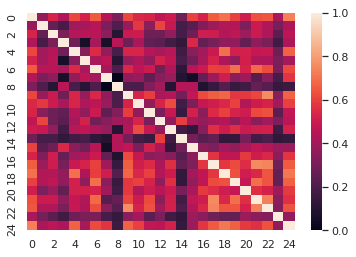

In [0]:
 ax = sns.heatmap(cosine_similarity(prs))

## Exploring positions (by price and in the page)

Hypothesis:


*   people would prefer to pay less
*   people are lazy and they choose the items at the top of the page



In [31]:
idxs = []
idxs_price = []


for i, row in train.iterrows():
  reference = int(row['reference'])
  impressions = list(map(int, row['impressions'].split('|')))
  prices = list(map(int, row['prices'].split('|')))

  try:
    idx = impressions.index(reference)
    idx_price = list(np.argsort(prices)).index(idx)
    idxs.append(idx)
    idxs_price.append(idx_price)
  except ValueError:
    print('Item not in the impressions...')
    idxs.append(None)
    idxs_price.append(None)

  if i % 10_000 == 0:
    print(i)


Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
60000
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
Item not in the impressions...
It

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2063dc3278>]],
      dtype=object)

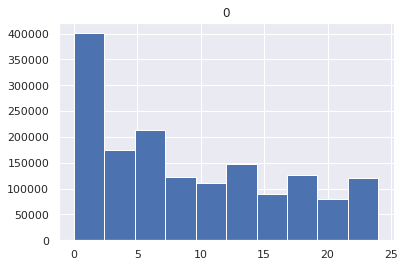

In [36]:
pd.DataFrame(idxs_price).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2063d8c240>]],
      dtype=object)

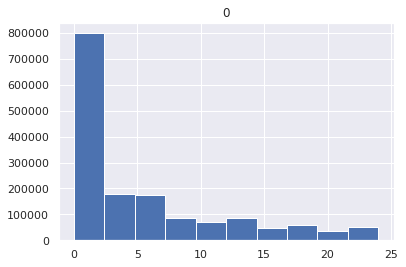

In [37]:
pd.DataFrame(idxs).hist()

In [35]:
len(properties) * 25

3925

In [0]:
train['idxs'] = pd.Series(idxs)

In [0]:
train['idxs_price'] = pd.Series(idxs_price)

In [0]:
train.to_csv('clickouts_w_idxs_prices.csv')